# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 6 декабря 2017, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 6 декабря, -4 балла после 06:00 13 декабря, -6 баллов после 06:00 20 декабря

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
%matplotlib inline
from tqdm import tqdm
from sklearn.metrics import accuracy_score

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Определям, что вам досталось

<center><img src='https://static1.squarespace.com/static/571a6e39b6aa608067028725/t/577988518419c2d62fb5922f/1467582555915/'></center>

Укажите свою фамилию на русском языке в поле ниже.

In [2]:
USER_NAME = u"Беляев".lower()
REGULARIZATIONS = ["L1", "L2"]
ALGORITHM = ["", "Mini Batch"]

print "Имплементируйте обучение логистической регрессии с %s регуляризацией с помощью метода %s Stochastic Gradient Descent (SGD)"\
% (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    ALGORITHM[hash(USER_NAME[::-1]) % 2]
)

Имплементируйте обучение логистической регрессии с L2 регуляризацией с помощью метода Mini Batch Stochastic Gradient Descent (SGD)


#### Замечания
* В SGD градиент расчитывается по одному случайному объекту, т.е. в алгоритме надо
    * Перемешать выборку
    * Посчтитать градиент на одном объекте
    * Сделать шаг спуска
* В Mini Batch SGD - по подвыборке объектов т.е в алгоритме надо
    * Перемешать выборку
    * Разбить на части (примерно) одинакового размера - мини батчи
    * Почитать градиент по мини батчам
    * Сделать шаг спуска
* Сделайте убывающую скорость спуска, например `alpha/n_epoch` или `alpha/n_iter` или `alpha/n_batch` или ...
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации/батча/эпохи.
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в обучающей выборке (тем или иным способом)

# Реализация модели

## Вывод правила обновления весов (1 балл)

Выведите правило обновления весов на каждом шаге алгоритма. Иными словами, посчитайте производную (градиент) функции потерь с регуляризацией. Формулы надо оформлять в формате LaTeX.

$$ \frac{\partial L}{\partial w_i} = -[\sum_{j} \frac{e^{-y^{(j)}(w^T x+w_0)}}{1 + e^{-y^{(j)}(w^T x+w_0)}}y^{(j)}x^{(j)}_{i}] + \frac{2 w_i}{C} = -[\sum_{j} \frac{1}{1 + e^{y^{(j)}(w^T x+w_0)}}y^{(j)}x^{(j)}_{i}] + \frac{2 w_i}{C} $$ 
$$ \frac{\partial L}{\partial w_0} = -[\sum_{j} \frac{1}{1 + e^{y^{(j)}(w^T x+w_0)}}y^{(j)}] $$

<center><img src='images/overfitting.jpg'></center>
* Как искать $w$? - c помощью градиентного спуска!
* А что с регуляризацией? - та же история 
    * Lasso: $ \frac{1}{C} \sum\limits_{j=1}^d |w_j|$
    * Rigde: $ \frac{1}{C} \sum\limits_{j=1}^d w_j^2$

## Имплементация (5 баллов)

In [3]:
from sklearn.base import BaseEstimator, ClassifierMixin

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """
    
    def __init__(self, C=1, alpha=0.01, max_epoch=1000, n_batch = 100):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """
        
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.n_batch = n_batch # Number of batches
    
    def fit(self, X, y=None):
        epoch_counter = 1
        if(type(y) == None):
            raise Exception("Supervised learning")
        
        # Transform y {0,1} into {-1,1}
        y_fixed = 2 * y - 1
        
        self.w_ = np.zeros(X.shape[1] + 1)
        self.log_loss_ = [] # Initialise array of losses
        X_fit = np.hstack([np.ones((X.shape[0],1)),X]) 
        
        while(epoch_counter < self.max_epoch):
            # Create batches
            meshed_indexes = np.arange(X_fit.shape[0])
            meshed_indexes = np.random.permutation(meshed_indexes).astype(int)
            meshed_indexes = np.array_split(meshed_indexes, self.n_batch)
            
            # Losses gradient
            for index, batch in enumerate(meshed_indexes):
                X_batch = X_fit[batch]
                y_batch = y_fixed[batch]
                
                exp_part = np.exp((X_batch * self.w_).sum(axis = 1) * y_batch)
                exp_part = y_batch / (1 + exp_part)
                
                # Making [0,w_1,...] array for regularization part of gradient
                w_increase = np.copy(self.w_) 
                w_increase[0] = 0
                
                increase = -(X_batch * exp_part[:,np.newaxis]).sum(axis = 0) + 2 / self.C * w_increase
                self.w_ -= (increase / np.sqrt(epoch_counter + 3)) * self.alpha / np.log(self.n_batch)
                '''This magic with sqrt and log is for 2 purposes:
                - need to have good convergence
                - need not to overflow in exponent if C is ~0.001 or smaller
                If C > 0.001 - increase / epoch_counter * self.alpha is fast and converges well
                So this Notebook works for ~12 min. If you want more speed:
                self.w_ -= (increase / epoch_counter) * self.alpha
                In testing:
                C_list = np.logspace(3, -2, 10)
                '''
            epoch_counter += 1
            self.log_loss_.append((1 + np.exp(-y_fixed * (X_fit * self.w_).sum(axis = 1))).sum(axis = 0) / 
                                  X_fit.shape[0] + (self.w_[1:] ** 2).sum() / self.C)
        return self
    
    def partial_fit(self, X, y=None):
        '''
        По желанию - метод дообучения модели на новых данных
        '''
        return self
        
    def predict(self, X):
        return np.sign((X * self.w_[1:]).sum(axis = 1) +  self.w_[0]).astype(int) / 2. + 0.5
        
    
    def predict_proba(self, X):
        p_1 = 1./(1 + np.exp(-((X * self.w_[1:]).sum(axis = 1) +  self.w_[0])))
        return np.column_stack((p_1, 1 - p_1))

## Проверка на синтетических данных (1 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

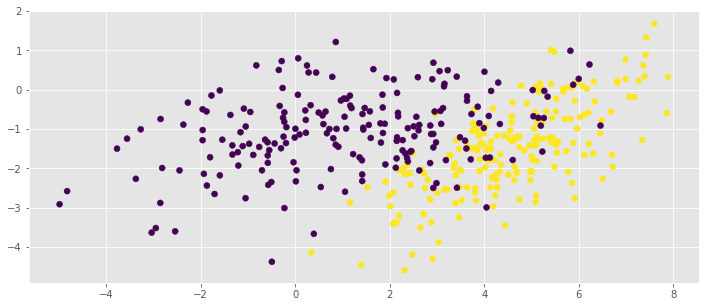

In [4]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

plt.scatter(X[:,0], X[:,1], c=y)

0.86
[-1.67370513  0.47539655 -0.22240009]


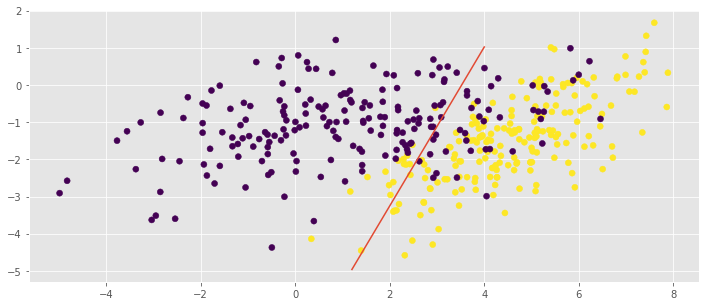

In [5]:
my_logres = MySGDClassifier(max_epoch = 1000).fit(X, y)
result = my_logres.predict(X)
plt.scatter(X[:,0], X[:,1], c=y)
x_plt = (np.arange(15)+6)*0.2
w = my_logres.w_
y_plt = (-w[0] - w[1] * x_plt) / w[2]
plt.plot(x_plt, y_plt)

print accuracy_score(y, result)
print w

### Улучшим 

100%|██████████| 24/24 [01:06<00:00,  2.76s/it]

Max accuracy 0.89
n_batch 8


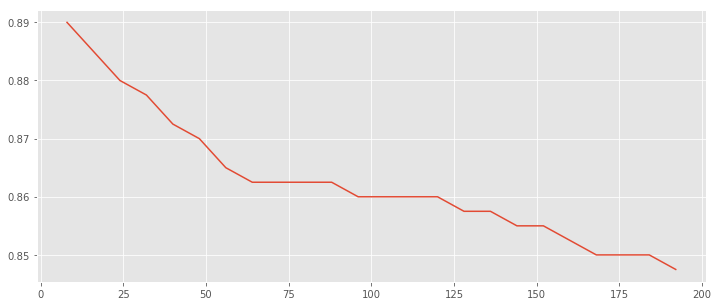

In [6]:
batch_nums = np.arange(1,25) * 8 
accur = []
for b_num in tqdm(batch_nums):
    accur.append(accuracy_score(y, MySGDClassifier(n_batch = b_num).fit(X, y).predict(X)))
plt.plot(batch_nums, accur)
print "Max accuracy",np.array(accur).max()
print "n_batch", batch_nums[np.array(accur).argmax()]

100%|██████████| 24/24 [00:08<00:00,  2.87it/s]

Max accuracy 0.895
alpha 0.012


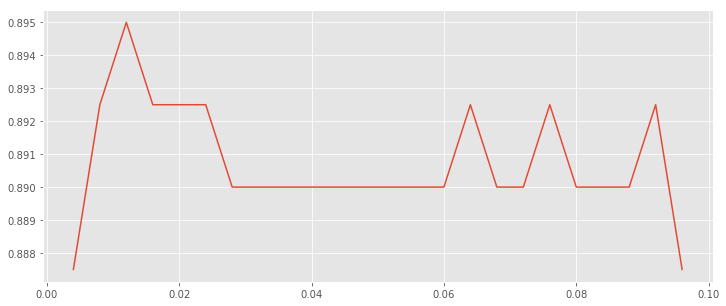

In [7]:
alpha_lst = np.arange(1,25)*0.004 
accur = []
for c in tqdm(alpha_lst):
    accur.append(accuracy_score(y, MySGDClassifier(alpha = c, n_batch = 8).fit(X, y).predict(X)))
plt.plot(alpha_lst,accur)
print "Max accuracy",np.array(accur).max()
print "alpha", alpha_lst[np.array(accur).argmax()]

100%|██████████| 24/24 [00:07<00:00,  3.12it/s]


Max accuracy = 0.9
C =  1.6


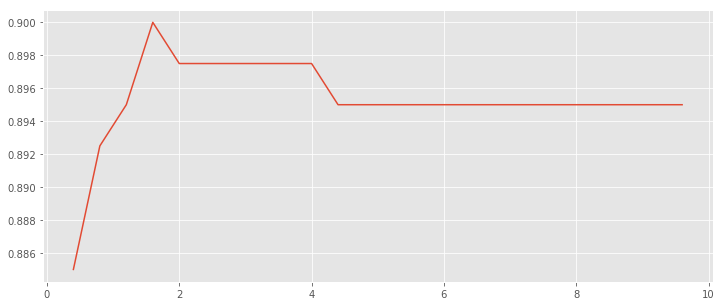

In [8]:
reg_coeffs = np.arange(1,25) * 0.4 
accur = []
for coef in tqdm(reg_coeffs):
    accur.append(accuracy_score(y, MySGDClassifier(C = coef, n_batch = 8, alpha = 0.012).fit(X, y).predict(X)))
plt.plot(reg_coeffs,accur)
print "Max accuracy =", np.array(accur).max()
print "C = ", reg_coeffs[np.array(accur).argmax()]

0.9
[-4.34790716  0.9891066  -0.97778229]


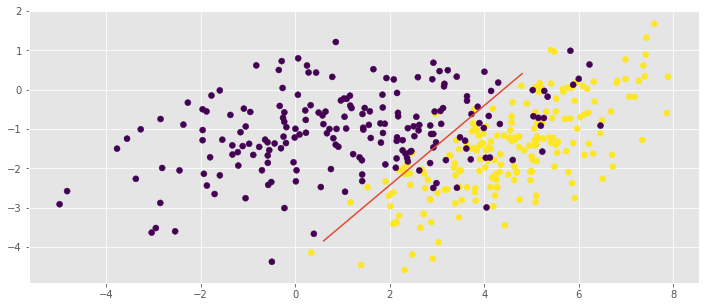

In [9]:
my_logres = MySGDClassifier(max_epoch = 1000, C = 1.6, n_batch = 8, alpha = 0.012).fit(X, y)
result = my_logres.predict(X)
plt.scatter(X[:,0], X[:,1], c=y)
x_plt = (np.arange(15)+2)*0.3
w = my_logres.w_
y_plt = (-w[0] - w[1] * x_plt) / w[2]
plt.plot(x_plt, y_plt)

print accuracy_score(y, result)
print w

## Анализ сходимости (2 балла)

Для следующих заданий используйте датасет ниже

In [10]:
from sklearn.datasets import make_classification

In [11]:
X, y = make_classification(n_samples=100000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/батча/эпохи (выбрать одно) для разных `alpha`.

100%|██████████| 4/4 [02:33<00:00, 38.46s/it]


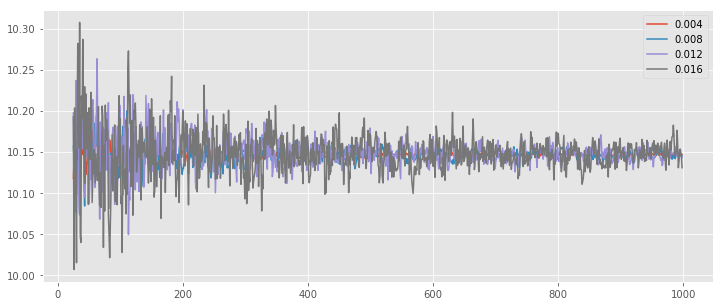

In [12]:
alpha_lst = np.arange(1,5) * 0.004
for alpha_ in tqdm(alpha_lst):
    my_clf = MySGDClassifier(C=1, max_epoch = 1000, alpha = alpha_, n_batch = 500)
    my_clf.fit(X, y)
    log_loss = my_clf.log_loss_
    plt.plot(range(25,len(log_loss)), log_loss[25:])
    plt.legend(alpha_lst)

## Эффект регуляризации (2 балла)

Изобразите значения коэффициентов модели для каждого С из `np.logspace(3, -3, 10)` (желательно на одном и том же графике)

 90%|█████████ | 9/10 [04:00<00:26, 26.74s/it]/home/vladimir/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:43: RuntimeWarning: overflow encountered in exp
/home/vladimir/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:62: RuntimeWarning: overflow encountered in exp
100%|██████████| 10/10 [04:27<00:00, 26.71s/it]


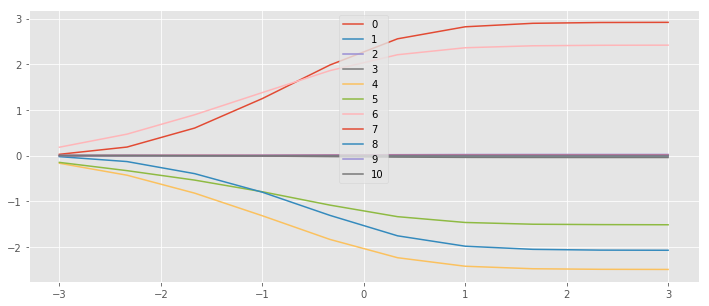

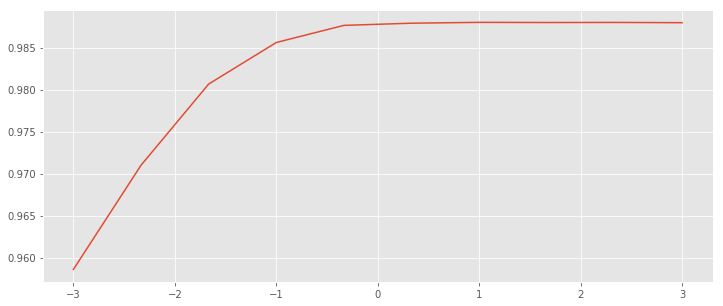

In [13]:
C_list = np.logspace(3, -3, 10)
w_list = np.empty((10, X.shape[1]+1))
accur = []
for ind,c in enumerate(tqdm(C_list)):
    my_clf = MySGDClassifier(C = c, max_epoch = 1000).fit(X, y)
    w_list[ind,:] = my_clf.w_
    accur.append(accuracy_score(y, my_clf.predict(X)))
figure_w = plt.figure()
ax = figure_w.add_subplot(1, 1, 1)
for ind in range(w_list.shape[1]):
    ax.plot(np.log10(C_list), w_list[:,ind])
ax.legend(range(w_list.shape[1]))
figure_accur = plt.figure()
ax2 = figure_accur.add_subplot(1, 1, 1)
ax2.plot(np.log10(C_list),accur)

# Боевое применение

## О hearthstone

[Hearthstone](http://eu.battle.net/hearthstone/ru/) - карточная он-лайн игра по мотивам вселенной Warcraft.

Каждый игрок играет за персонажа определенного класса и собирает колоду карт которую может разыгрывать во время игры. Для дальнейших деталей обратитесь к [wiki](https://ru.wikipedia.org/wiki/Hearthstone), посмотрите youtube или поиграйте сами (но не долго =) ).

Теми или иными способами игрок может отнимать жизни у своего оппонента, таким образом цель раунда - побить другого игрока.

<center><img src='http://ps3hits.ru/wp-content/uploads/2015/08/hearthstone-game-sshot-1.jpg'></center>

## Постановка задачи

В рамках конференции [AAIA 17](https://fedcsis.org/2017/aaia) было запущено [соревнование](https://knowledgepit.fedcsis.org/contest/view.php?id=120) по предсказанию исхода раунда в heartstone. 

Используя признаки, которые описывают текущее состояние раунда необходимо предсказать **вероятность** победы игрока в этом раунде.

Качество модели измеряется с помощью **ROC-AUC**

## Данные

Обучающую выборку и тестовую выборку с ответами можно скачать [отсюда](https://cloud.mail.ru/public/BEon/4Rrdqqvng)

Данные содержат набор информации о раунде в некоторый момент времени: жизни игрока и оппонента, номер хода, карты на столе, карты в руке игрока, количество карт в руке оппонента и тп.<br/>
По игроку №1 (далее просто **игрок**) помимо всего прочего известен набор карт "в руке".</br>
По игроку №2 (далее просто **оппонент**) эта информация отсутствует.</br>


В данных для обучению содержится 2 млн. игр, разбитых на 4 файла. Названия признаков говорят сами за себя.
Целевой признак - `decision` (1 - победил игрок, 0 - победил оппонент).

## Работа с простыми табличными данными (1 балл)

По соображениям сокращения времени вычислений, проделаем основные шаги по одной части данных.

Если все данные не будут помещаться вам с оперативную память, то можете использовать один из 4х файлов для обучения

In [14]:
# Загрузка данных целиком
df_list = []
for chunk in range(1,5):
    filepath = './lin_model_hw/trainingData_tabular_chunk%d.csv' % chunk
    df_list.append(pd.read_csv(filepath, sep=','))
df_data = pd.concat(df_list)

# Загрузка одной части данных
# filepath = './trainingData_tabular_chunk1.csv'
# df_data = pd.read_csv(filepath, sep=',')

In [15]:
df_data.shape

(2000000, 45)

In [16]:
# для удобства
df_data.columns = df_data.columns.str.replace('.', '_')
df_data = df_data.set_index('gamestate_id')

In [17]:
df_data.head().T

gamestate_id,4687346.0,3270826.0,3189487.0,4098946.0,2661127.0
decision,1,1,1,1,0
turn,14,7,5,8,13
opponent_armor,0,0,3,0,0
opponent_attack,0,0,0,0,0
opponent_hero_card_id,798,754,612,390,25
opponent_hp,5,22,29,26,30
opponent_special_skill_used,0,0,0,0,0
opponent_weapon_durability,0,0,0,0,0
opponent_crystals_all,10,6,4,7,10
opponent_crystals_current,10,6,1,7,1


In [18]:
# Распределение классов
df_data.decision.mean()

# Примерно поровну

0.5047995

#### Задание

* Определите количество уникальных карт героя у игрока и оппонента.
* Преобразуйте категориальные переменные с помощью one-hot кодирования, добавьте к датасету и удалите прежние столбцы


In [19]:
print "Player has", df_data['player_hero_card_id'].unique().shape[0], "unique cards"
print "Opponent has" , df_data['opponent_hero_card_id'].unique().shape[0], "unique cards"


Player has 9 unique cards
Opponent has 9 unique cards


In [20]:
from sklearn.preprocessing import OneHotEncoder
player_ohe = OneHotEncoder().fit_transform(df_data['player_hero_card_id'].values.reshape(-1, 1)).toarray().astype(int)
opponent_ohe = OneHotEncoder().fit_transform(df_data['opponent_hero_card_id'].values.reshape(-1, 1)).toarray().astype(int)

In [21]:
player_ohe

array([[0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0]])

In [22]:
for ind, card in enumerate(df_data['player_hero_card_id'].unique()):
    df_data['player_hero_card_%d' % card] = player_ohe[:,ind]
for ind, card in enumerate(df_data['opponent_hero_card_id'].unique()):
    df_data['opponent_hero_card_%d' % card] = opponent_ohe[:,ind]
del df_data['opponent_hero_card_id']
del df_data['player_hero_card_id']

In [23]:
df_data.head().T

gamestate_id,4687346.0,3270826.0,3189487.0,4098946.0,2661127.0
decision,1,1,1,1,0
turn,14,7,5,8,13
opponent_armor,0,0,3,0,0
opponent_attack,0,0,0,0,0
opponent_hp,5,22,29,26,30
opponent_special_skill_used,0,0,0,0,0
opponent_weapon_durability,0,0,0,0,0
opponent_crystals_all,10,6,4,7,10
opponent_crystals_current,10,6,1,7,1
opponent_deck_count,11,19,22,17,12


Вроде бы других категориальных нет

## Обучение модели (1 балл)

#### Задание

* Получите матрицу объект признак `X` и вектор целевого признака `y`
* Создайте Pipeline из `StandartScaller` и вашей модели
* Обучите модель (подбирать гиперпараметры можно без фанатизма)

In [24]:
X = df_data.iloc[:,1:].values
y = df_data.iloc[:,0].values

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
estimator = MySGDClassifier()
pipe = Pipeline(steps = [('std_scaler', scaler),('clf', estimator)])

In [26]:
from sklearn.model_selection import GridSearchCV
params = {'clf__alpha': (0.01, 0.001, 0.0001), 'clf__max_epoch': (100,  500), 'clf__C': (0.1, 1, 10), 'clf__n_batch': (16, 100)}
grid = GridSearchCV(pipe, params, verbose = 1).fit(X[100000:110000], y[100000:110000])

Fitting 3 folds for each of 36 candidates, totalling 108 fits


/home/vladimir/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:  2.4min finished


In [27]:
print grid.best_estimator_
print grid.best_score_

Pipeline(steps=[('std_scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', MySGDClassifier(C=10, alpha=0.01, max_epoch=100, n_batch=16))])
0.7024


In [28]:
model = grid.best_estimator_.fit(X[:50000], y[:50000])
#model = grid.best_estimator_.fit(X, y) #Можно, нужно, но очень долго. Не обучится до дедлайна :(

In [29]:
result = model.predict(X[150000:250000])
accuracy_score(result,y[150000:250000])

0.66473000000000004

## Применение модели (2 балла)
#### Задание
* Загрузите тестовые данные
* Подготовте их к подаче на вход в алгоритм
* Примените модель оцените качество с помощью меры ROC-AUC


In [30]:
del df_data
del X
del y

In [31]:
# Загрузка одной части данных
filepath = './lin_model_hw/testData_tabular_chunk6.csv'
df_data = pd.read_csv(filepath, sep=',')

In [32]:
# То же самое, что и с training_set
df_data.columns = df_data.columns.str.replace('.', '_')
df_data = df_data.set_index('gamestate_id')
player_ohe = OneHotEncoder().fit_transform(df_data['player_hero_card_id'].values.reshape(-1, 1)).toarray().astype(int)
opponent_ohe = OneHotEncoder().fit_transform(df_data['opponent_hero_card_id'].values.reshape(-1, 1)).toarray().astype(int)
for ind, card in enumerate(df_data['player_hero_card_id'].unique()):
    df_data['player_hero_card_%d' % card] = player_ohe[:,ind]
for ind, card in enumerate(df_data['opponent_hero_card_id'].unique()):
    df_data['opponent_hero_card_%d' % card] = opponent_ohe[:,ind]
del df_data['opponent_hero_card_id']
del df_data['player_hero_card_id']
X = df_data.iloc[:,1:].values

In [33]:
y = pd.read_csv('./lin_model_hw/deprecated_testLabels.txt', sep=" ", header=None)
y = y.values

In [34]:
result = model.predict(X)

In [35]:
from sklearn.metrics import roc_auc_score
roc_auc_score(result,y[500000:1000000])

0.6777047630281926